##  Loading of dependencies and dataset

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import shutil
import random
from ultralytics import YOLO

In [ ]:
!rmdir /content/datasets

HOME = os.getcwd()
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rfIDWoGPZDV0R2uGDIyc")
project = rf.workspace("yong-hann-choo-wdvd2").project("planets-hmb4g")
version = project.version(9)
dataset = version.download("yolov8")



In [ ]:
# Normalise training data
import os
import cv2

image_dir = "/content/datasets/Planets-9/train/images"

def normalize_image_inplace(image):
    image = image.astype(float)
    image /= 255.0

for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(image_dir, filename)
        image = cv2.imread(filepath)
        normalize_image_inplace(image)
        cv2.imwrite(filepath, image)

## Training and Finetuning YOLOv8 model

In [ ]:
# CONSTANTS
IMAGE_SIZE = 640
OPTIMISER = 'SGD'
LEARNING_RATE = 0.01
BATCH_SIZE = 10
EPOCHS = 20
CLOSE_MOSAIC = 10

training_data = str(dataset.location) + "/data.yaml"



In [ ]:
# utilise pretrained model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')
results = model.train(data=training_data, epochs=EPOCHS, imgsz=IMAGE_SIZE, lr0=LEARNING_RATE, batch=BATCH_SIZE, optimizer=OPTIMISER, close_mosaic=CLOSE_MOSAIC, degrees=20)

## Testing of model

Image Size - Width: 1600, Height: 1131

image 1/1 /content/drive/MyDrive/Test2.jpg: 704x960 1 Earth, 26.4ms
Speed: 4.5ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 704, 960)
confidence score: [    0.70846]
[0]


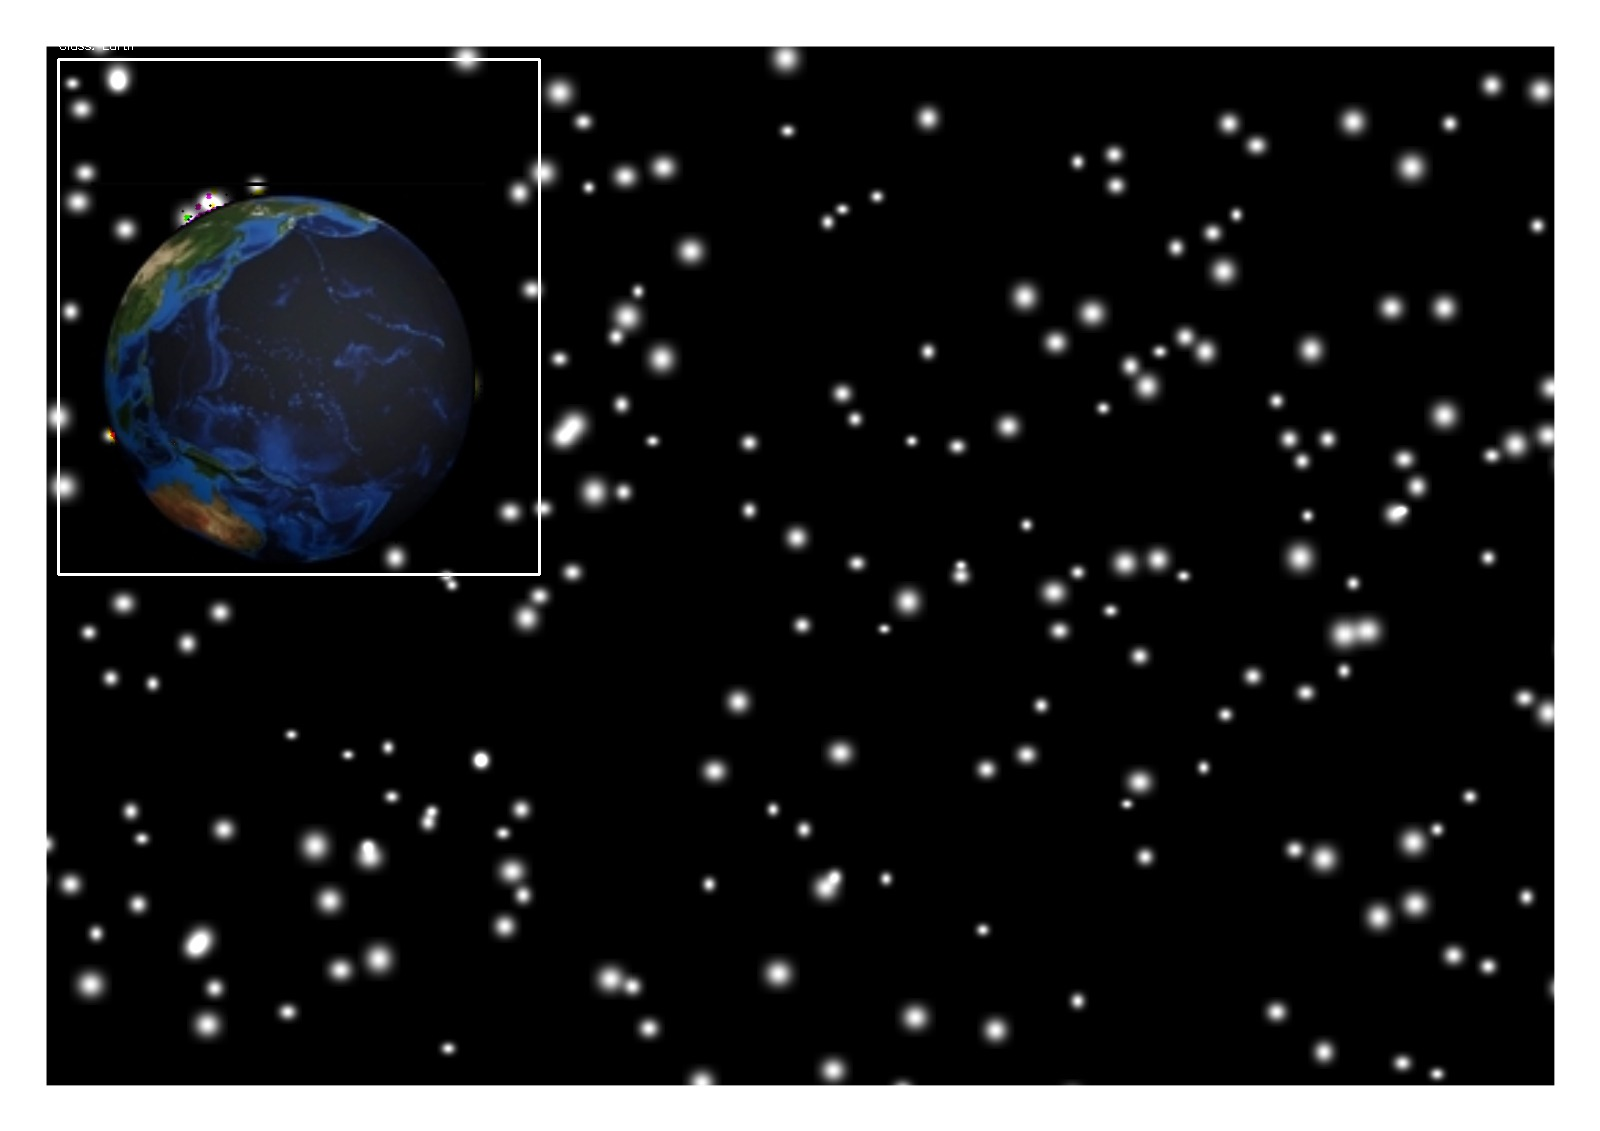

In [ ]:
#
import cv2
import numpy as np
from PIL import Image
import os
import shutil
from google.colab.patches import cv2_imshow

image_path = '/content/drive/MyDrive/Test2.jpg'
img = cv2.imread(image_path)
height, width, _ = img.shape
print(f"Image Size - Width: {width}, Height: {height}")

model = YOLO('/content/datasets/runs/detect/train/weights/best.pt')
result = model.predict(image_path, imgsz = 960, conf = 0.5, iou = 0.5)
class_name = model.names

# get boxes on cpu in numpy
boxes = result[0].boxes.cpu().numpy()
print ("confidence score:", (boxes.conf))
labels = boxes.cls.astype(int).tolist()

print(labels)

original_image = cv2.imread(image_path)

# Draw bounding boxes on the original image
for box, label in zip(boxes, labels):
    # get corner points as int
    r = box.xyxy[0].astype(int)
    cv2.rectangle(original_image, tuple(r[:2]), tuple(r[2:]), (255, 255, 255), 2)

    # Add class label text
    cv2.putText(original_image, f"Class: {class_name[label]}", (r[0], r[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

# Display the modified image with bounding boxes
cv2_imshow(original_image)